In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [5]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    w, w_0 = Initialw(X, y)
    n, d = X.shape

    X_1 = np.hstack((X, np.ones(n).reshape(n,1)))
    W = np.hstack((w, w_0))

    iterations = []
    losses = []

    # coordinate descent
    for i in range(max_iter):
        prev_W = np.copy(W)

        # update w_j
        for j in range(d+1):
            mask = np.hstack((np.arange(j),np.arange(j+1, d+1)))
            r = y - np.matmul(X_1[:,mask], W[mask])  

            a = np.dot(X_1[:,j].T, X_1[:,j])
            c = np.dot(r, X_1[:,j])

            # soft threshold
            if c < -lmda:
                W[j] = (c + lmda) / a
            elif c > lmda:
                W[j] = (c - lmda) / a
            else:
                W[j] = 0

        # calculate loss
        residual = np.matmul(X_1, W) - y
        mse_loss = 0.5 * np.matmul(residual.T, residual)
        l1_norm = lmda * np.sum(np.abs(W[:-1]))      # exclude the bias term w_0 in W
        loss = mse_loss + l1_norm
        
        losses.append(loss)
        iterations.append(i+1)

        # check convergence
        if (np.abs(W - prev_W) < epsilon).all():
            break
    if draw_curve is True:
        plt.plot(iterations, losses)
        plt.xlabel("Iterations")
        plt.ylabel("Objective function")
        plt.show()

    
            
    w, w_0 = W[:d], W[d]
    return (w,w_0)

In [6]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

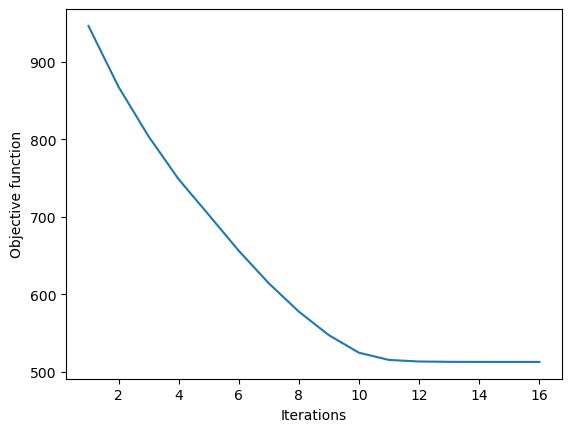

[ 9.82243211e+00 -9.70448622e+00 -9.71773157e+00  9.80143744e+00
  9.90682765e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.36135868e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.88912094e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.70781818e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.17640377e-02  0.00000000e+00
 -1.22719281e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.33623413e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [7]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
print(w0_lasso)

true_non_zero_indices = [i for i in range(len(w_true)) if w_true[i] != 0]
predicted_non_zero_indices = [i for i in range(len(w_lasso)) if w_lasso[i] != 0]

print(true_non_zero_indices)
print(predicted_non_zero_indices)

In [8]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    non_zero_indices = [i for i in range(len(w)) if w[i] != 0]
    non_zero_indices_true = [i for i in range(len(w_true)) if w_true[i] != 0]

    sparsity_w = len(non_zero_indices)
    
    intersection = set(non_zero_indices).intersection(non_zero_indices_true)
    precision_w = len(intersection) / len(non_zero_indices) if len(non_zero_indices) > 0 else 1
    recall_w = len(intersection) / len(non_zero_indices_true) if len(non_zero_indices_true) > 0 else 1

    # rmse
    n = X.shape[0]
    y_pred = np.matmul(X, w) + w0
    e = y_pred - y
    rmse = np.sqrt(np.matmul(e.T, e) / n)
    
    return (rmse, sparsity_w, precision_w, recall_w)

In [9]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print(f"rmse: {Emetric[0]}")
print(f"sparsity: {Emetric[1]}")
print(f"precision: {Emetric[2]}")
print(f"recall: {Emetric[3]}")

rmse: 0.8593051741739723
sparsity: 13
precision: 0.38461538461538464
recall: 1.0


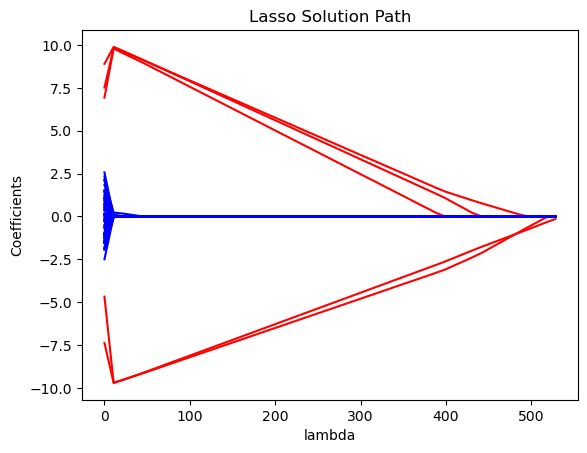

(array([[ 7.51844778,  9.8130805 ,  9.60174094, ...,  0.        ,
          0.        ,  0.        ],
        [-4.67416969, -9.6959014 , -9.5239019 , ..., -0.34237055,
         -0.05408887,  0.        ],
        [-7.37606445, -9.70415134, -9.53067957, ..., -0.5516847 ,
         -0.34372747, -0.14621087],
        ...,
        [ 0.60685953,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.40377226,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.21314915,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([-1.52379843,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        

In [10]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    number_of_lambda = 50
    W = np.zeros((X.shape[1], number_of_lambda))     # the coefficient of each feature under different lambda
    W0 = np.zeros(number_of_lambda)          # bias term

    max_lambda = np.max(np.abs((y - np.mean(y)).dot(X)))
    min_lambda = 0
    Lmda = np.linspace(min_lambda, max_lambda, number_of_lambda)    # array
    
    for idx, lmda in enumerate(Lmda):
        w_lasso, w0_lasso = lasso(X, y, lmda = lmda, draw_curve = False)
        W[:, idx] = w_lasso
        W0[idx] = w0_lasso    

    # draw lasso solution path
    for i in range(X.shape[1]):
        # red represents that it is an important feature 
        if w_true[i] != 0: 
            plt.plot(Lmda, W[i, :], c = 'r')
        else:
            plt.plot(Lmda, W[i, :], c = 'b')
    if w0_true != 0:
        plt.plot(W0, c = 'r')
    else:
        plt.plot(W0, c = 'b') 
    plt.xlabel('lambda')
    plt.ylabel('Coefficients')

    plt.title("Lasso Solution Path")
    plt.show()
    return (W, W0, Lmda)
LassoPath(X, y)

In [11]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    RMSE = []
    Sparsity = []
    Precision = []
    Recall = []

    for i in range(len(Lmda)):
        w = W[:, i]    # coefficient under current lambda
        w0 = W0[i]     # interception under current lambda
        rmse, sparsity_w, precision_w, recall_w = Evaluate(X, y, w, w0, w_true, w0_true)
        RMSE.append(rmse)
        Sparsity.append(sparsity_w)
        Precision.append(precision_w)
        Recall.append(recall_w)
    plt.plot(Lmda, Precision, label="Precision")
    plt.plot(Lmda, Recall, label="Recall")
    plt.xlabel("Lambda")
    plt.legend(["Precision", "Recall"])
    plt.show()

    return (RMSE, Sparsity, Precision, Recall)

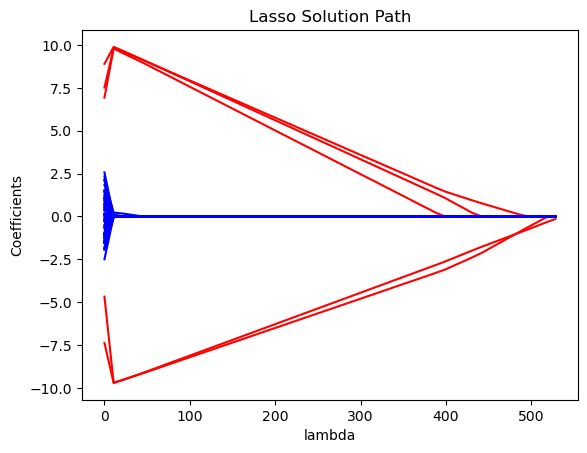

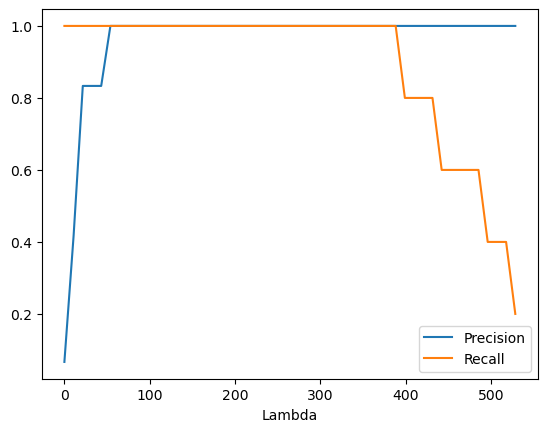

([0.0003116115299735952,
  0.8904413054000235,
  1.2718324159561496,
  1.6943494197236908,
  2.150828344040071,
  2.614861581345852,
  3.0868492242929437,
  3.565160025420957,
  4.0474044700166365,
  4.532330423244434,
  5.019164598925446,
  5.507401002197105,
  5.996696380227954,
  6.486813640181432,
  6.97757611549009,
  7.468634445147932,
  7.960351452854156,
  8.45241737461592,
  8.94477389005817,
  9.437375842007086,
  9.930187195384681,
  10.423177935302682,
  10.916323739571437,
  11.409605169050442,
  11.90301128917995,
  12.39653787979554,
  12.890153011400795,
  13.383849406448494,
  13.87761934759831,
  14.370853224848501,
  14.864783023783309,
  15.35876651749832,
  15.852798686501762,
  16.34687511762813,
  16.841394114888654,
  17.33550355489279,
  17.829448966209778,
  18.30593002858681,
  18.70911527512376,
  19.11429409351063,
  19.52125765835293,
  19.89397436291768,
  20.187914614723272,
  20.48456668066612,
  20.783814442068206,
  21.085547384271443,
  21.3755955709

In [12]:
### Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

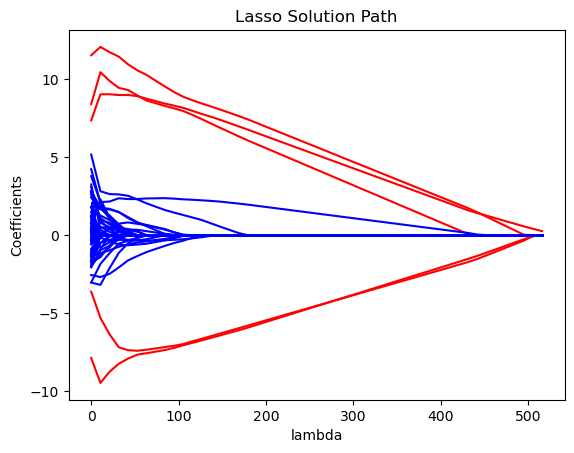

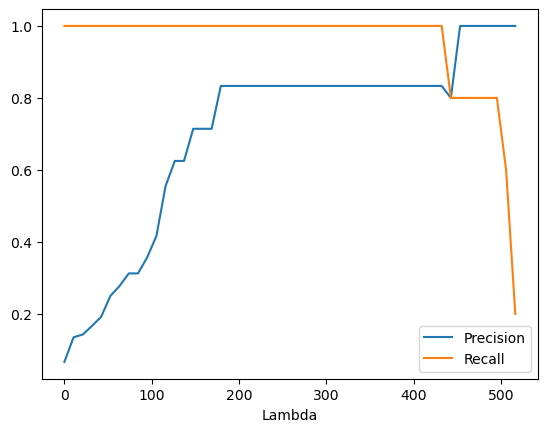

([0.0005311643037584886,
  2.2236185667904045,
  3.5806318041163854,
  4.810803267594283,
  5.686498083291357,
  6.331909146710508,
  6.898205506601755,
  7.379597146961498,
  7.896477080114977,
  8.368322523843345,
  8.808582941793025,
  9.184623513246036,
  9.556898441761822,
  9.912825999822196,
  10.28040957830667,
  10.657099120012735,
  11.045593377399797,
  11.429068080937862,
  11.790157480884723,
  12.160228188948839,
  12.538484729289513,
  12.92420796625887,
  13.316748681818023,
  13.715521709196501,
  14.119997845000528,
  14.529701494355201,
  14.944278445737012,
  15.363172799971965,
  15.786133058168227,
  16.212835603709067,
  16.642991264506293,
  17.076339089008528,
  17.512642109915916,
  17.951684856637584,
  18.393271140525652,
  18.83722208396418,
  19.2833774827832,
  19.731524242701827,
  20.18159123632861,
  20.633447824375736,
  21.086978963646487,
  21.54207889007832,
  21.945749631604727,
  22.318172594584887,
  22.685725821199334,
  23.05566404398365,
  23

In [13]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
W, W0, Lmda = LassoPath(X, y)
EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

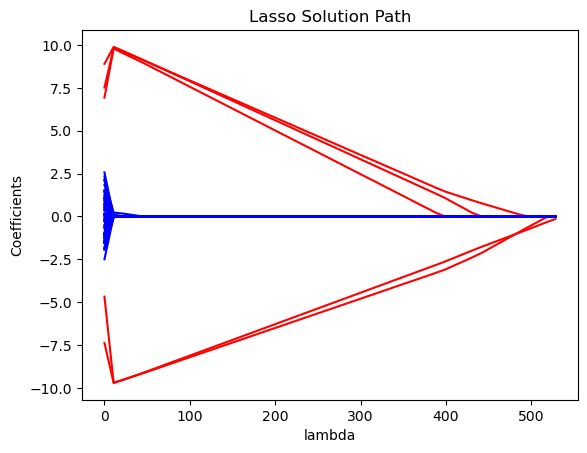

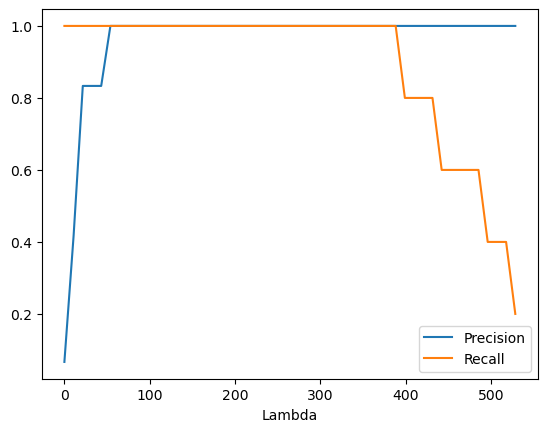

Optimal interval of \lambda is  53.90376553492914 388.10711185148983


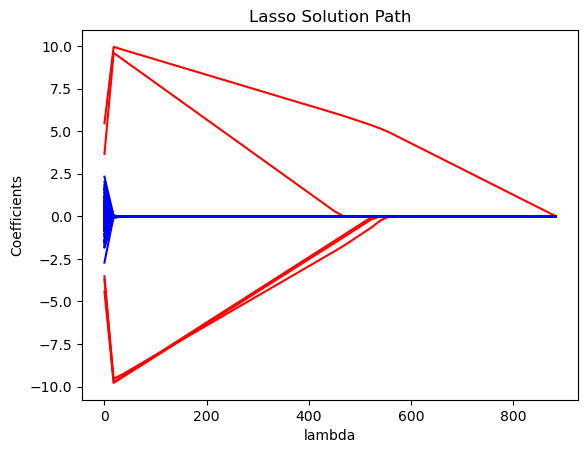

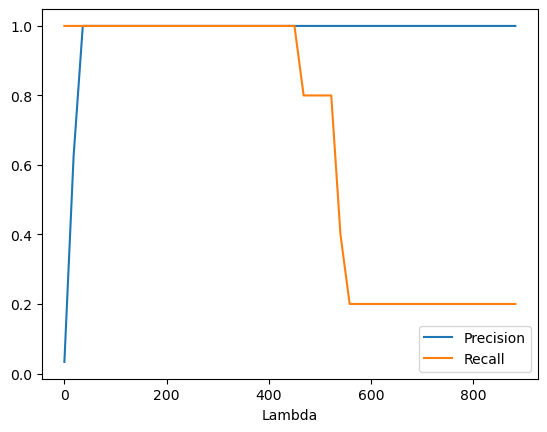

Optimal interval of \lambda is  36.03149416132464 450.39367701655794


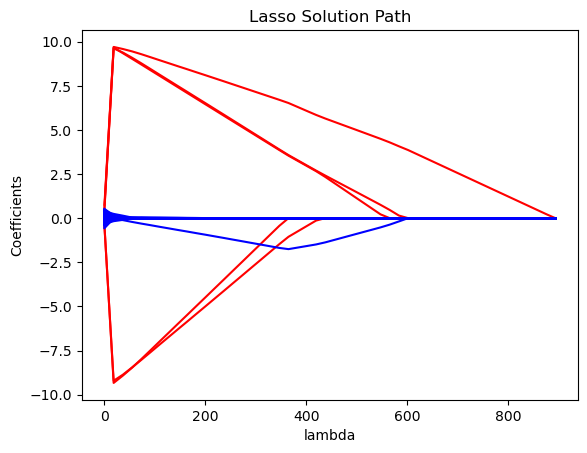

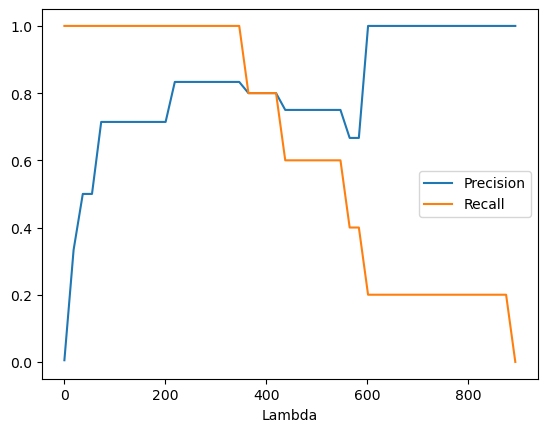

Optimal interval of \lambda is  364.45738253422655 419.1259899143605


/var/folders/j4/kk26gmps6pb74rjywjb8nmkc0000gn/T/ipykernel_28695/3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


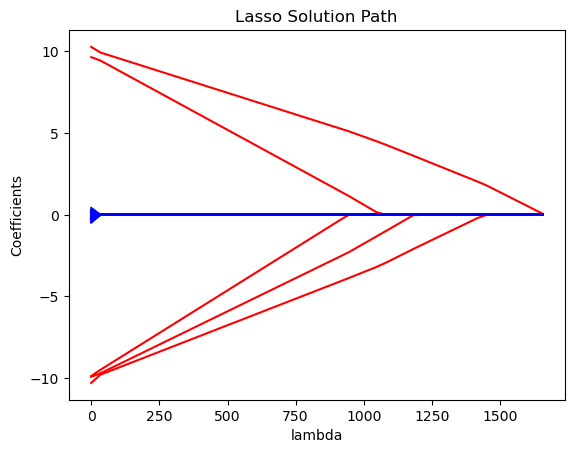

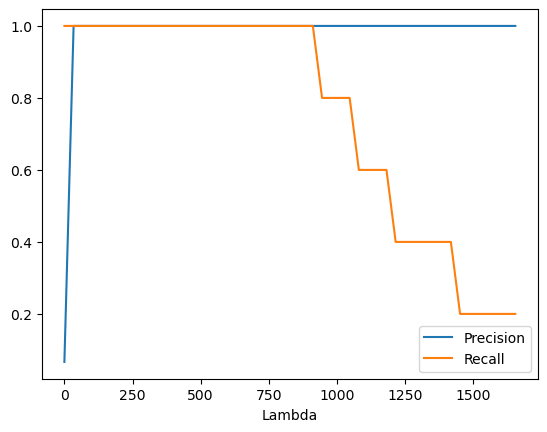

Optimal interval of \lambda is  33.755662095952886 911.4028765907279


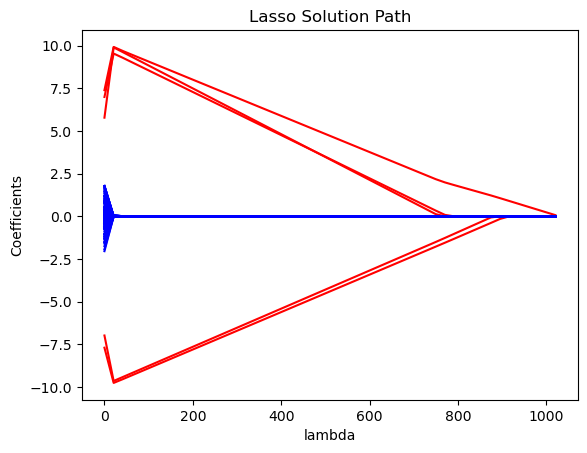

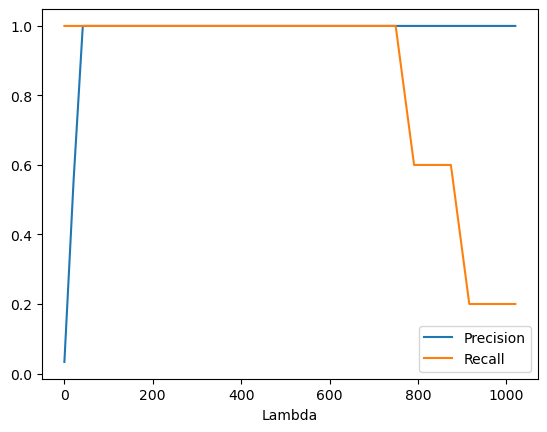

Optimal interval of \lambda is  41.640431997869165 749.5277759616449


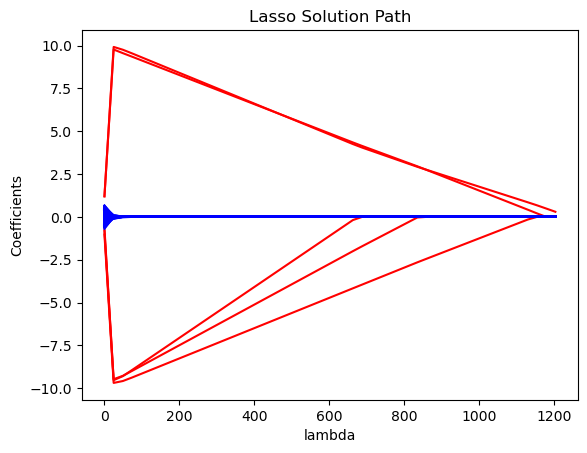

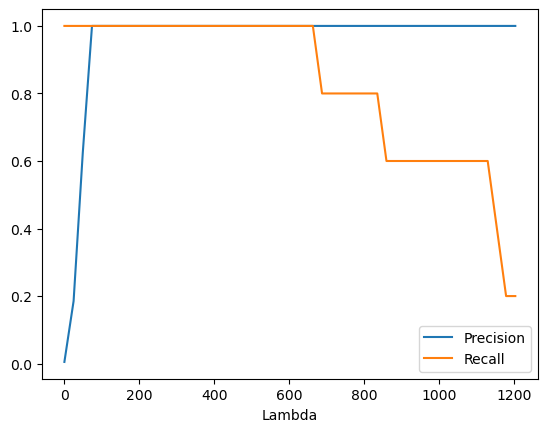

Optimal interval of \lambda is  73.70493900078691 663.3444510070822


In [14]:
## Sub-Problem 4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
parameters = [
    (50, 75),
    (50, 150),
    (50, 1000),
    (100, 75),
    (100, 150),
    (100, 1000)
]
for (n,d) in parameters:
    X, y, w_true, w0_true = DataGenerator(n, d, k=5, sigma=1.0)
    W, W0, Lmda = LassoPath(X, y)
    (RMSE, Sparsity, Precision, Recall) = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)
    try:
        optimal_lambda = [Lmda[i] for i in range(len(Lmda)) if Precision[i] == Recall[i] == 1.0]
        print("Optimal interval of \lambda is ",optimal_lambda[0], optimal_lambda[-1])
    except:
        optimal_lambda = [Lmda[i] for i in range(len(Lmda)) if Precision[i] == Recall[i]]
        print("Optimal interval of \lambda is ",optimal_lambda[0], optimal_lambda[-1])
        

In [15]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [16]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    return (w_lasso, w0_lasso, lmda_best)

In [17]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])

FileNotFoundError: [Errno 2] No such file or directory: '../data/star_features.txt'